# Calculating Sheet Resistances (Voltage Source)

Here we compare various parameters against sheet resistance with voltage sources.

See here: [http://hdl.handle.net/2262/85922](http://hdl.handle.net/2262/85922)
for more information on the graphs as these were meant to replicate those ones.

An additional package `joblib` is used in this notebook for quick parallelization. This is extra and not required for the `randomnwn` package.

Furthermore, `monitor.py` should be present with this notebook for runtime measurements.

These graphs should be the same as the current sources.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

from randomnwn import *
from monitor import *

from scipy.stats import linregress

%load_ext line_profiler

units = get_units()

## Test Network Creation

Creation: 0.8943707999999972


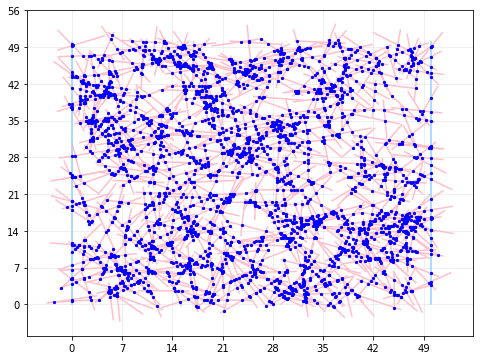

Plotting: 0.8748266999999998


In [2]:
length = 50.0 / units["l0"]
width = 50.0 / units["l0"]

with Runtime("Creation"):
    NWN = create_NWN(size=(length, width))
    left, right = add_electrodes(NWN, "left", "right")

with Runtime("Plotting"):
    plot_NWN(NWN, scaled=True)

In [3]:
with Runtime():
    current = solve_network(NWN, left, right, 30)[-1]
    print(current, "i0")

84.28983034193936 i0
Time elapsed: 0.018110099999994134


In [4]:
def sheet_resistance(NWN, left_node, right_node, voltage):
    current = solve_network(NWN, left_node, right_node, voltage)[-1]
    R_s = voltage / current
    return R_s

In [5]:
print(sheet_resistance(NWN, left, right, 30), "Ron")

0.35591482244416334 Ron


## R_s versus R_j Single Network

In [2]:
def resist_func(density, voltage, R_j, NWN_type="JDA"):
    density *= units["l0"]**2
    voltage /= units["v0"]
    R_j /= units["Ron"]
    size = 20.0 / units["l0"]

    # Create NWN
    NWN = create_NWN(size=size, conductance=1/R_j, density=density, seed=123)
    left, right = add_electrodes(NWN, "left", "right")
    if NWN_type == "MNR":
        convert_NWN_to_MNR(NWN)

    # Solve network voltages to get current and sheet resistance
    current = solve_network(NWN, left, right, voltage)[-1]
    return (voltage / current) * units["Ron"]

In [3]:
junction_array = np.linspace(0.001, 100, 400)
with Parallel(n_jobs=-1, verbose=9) as parallel:
    Rs_list_JDA = parallel([delayed(resist_func)(0.4, 10, R_j, "JDA") for R_j in junction_array])
    Rs_list_MNR = parallel([delayed(resist_func)(0.4, 10, R_j, "MNR") for R_j in junction_array])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 314 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    8.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  26

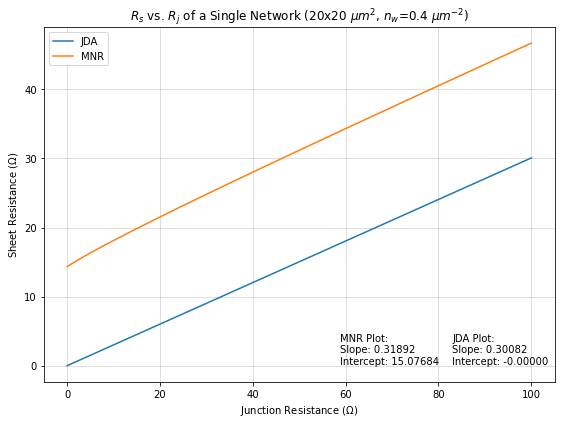

In [4]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(junction_array, Rs_list_JDA, label="JDA")
ax.plot(junction_array, Rs_list_MNR, label="MNR")
ax.set_xlabel(r"Junction Resistance ($\Omega$)")
ax.set_ylabel(r"Sheet Resistance ($\Omega$)")
ax.set_title(r"$R_s$ vs. $R_j$ of a Single Network (20x20 $\mu m^{2}$, $n_w$=0.4 $\mu m^{-2}$)")

slope, intercept, *_ = linregress(junction_array, Rs_list_JDA)
ax.text(0.8, 0.05, f"JDA Plot:\nSlope: {slope:.5f}\nIntercept: {intercept:.5f}", transform=ax.transAxes)

slope, intercept, *_ = linregress(junction_array, Rs_list_MNR)
ax.text(0.58, 0.05, f"MNR Plot:\nSlope: {slope:.5f}\nIntercept: {intercept:.5f}", transform=ax.transAxes)

ax.grid(alpha=0.5)
ax.legend()
fig.tight_layout()
# fig.savefig("figs/Sheet Resistance (Voltage)/fig1.jpg")

## R_s versus R_j Ensemble

In [5]:
def resist_func(density, voltage, R_j, NWN_type="JDA"):
    density *= units["l0"]**2
    voltage /= units["v0"]
    R_j /= units["Ron"]
    size = 20.0 / units["l0"]

    # Create NWN
    NWN = create_NWN(size=size, conductance=1/R_j, density=density)
    left, right = add_electrodes(NWN, "left", "right")
    if NWN_type == "MNR":
        convert_NWN_to_MNR(NWN)

    # Solve network voltages to get current and sheet resistance
    current = solve_network(NWN, left, right, voltage)[-1]
    return (voltage / current) * units["Ron"]

In [6]:
repeat_num = 20
junction_array = np.linspace(0, 100, 25)

with Parallel(n_jobs=-1, verbose=9) as parallel:
    Rs_list_JDA = parallel([delayed(resist_func)(0.4, 10, R_j, "JDA") for R_j in junction_array.repeat(repeat_num)])

Rs_list_JDA = np.array(Rs_list_JDA).reshape((-1, repeat_num))
avg_JDA = np.mean(Rs_list_JDA, axis=1)
std_JDA = np.std(Rs_list_JDA, axis=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 412 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 477 out of 500 | elapsed:    7.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    7.7s finished


In [7]:
repeat_num = 20
junction_array = np.linspace(0, 100, 25)

with Parallel(n_jobs=-1, verbose=9) as parallel:
    Rs_list_MNR = parallel([delayed(resist_func)(0.4, 10, R_j, "MNR") for R_j in junction_array.repeat(repeat_num)])

Rs_list_MNR = np.array(Rs_list_MNR).reshape((-1, repeat_num))
avg_MNR = np.mean(Rs_list_MNR, axis=1)
std_MNR = np.std(Rs_list_MNR, axis=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 314 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   17.7s finished


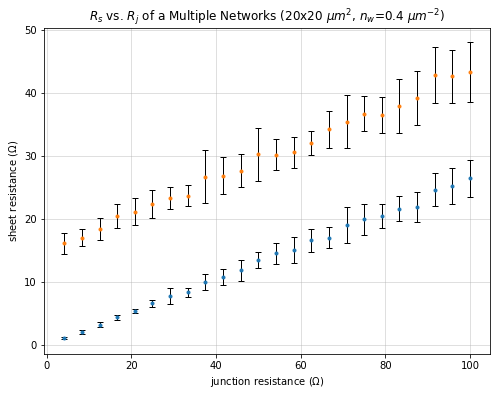

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(junction_array, avg_JDA, fmt=".", yerr=std_JDA, capsize=3, elinewidth=1, ecolor="black")
ax.errorbar(junction_array, avg_MNR, fmt=".", yerr=std_MNR, capsize=3, elinewidth=1, ecolor="black")
ax.set_title(r"$R_s$ vs. $R_j$ of a Multiple Networks (20x20 $\mu m^{2}$, $n_w$=0.4 $\mu m^{-2}$)")
ax.set_xlabel(r"junction resistance ($\Omega$)")
ax.set_ylabel(r"sheet resistance ($\Omega$)")
ax.grid(alpha=0.5)

## R_s versus resistivity Single Network

In [9]:
def resist_func(density, voltage, resistivity, R_j, NWN_type="JDA"):
    density *= units["l0"]**2
    voltage /= units["v0"]
    resistivity /= units["rho0"]
    R_j /= units["Ron"]
    size = 20.0 / units["l0"]

    # Create NWN
    NWN = create_NWN(size=size, conductance=1/R_j, density=density, resistivity=resistivity, seed=123)
    left, right = add_electrodes(NWN, "left", "right")
    if NWN_type == "MNR":
        convert_NWN_to_MNR(NWN)

    # Solve network voltages to get sheet resistance
    current = solve_network(NWN, left, right, voltage)[-1]
    return (voltage / current) * units["Ron"]

In [10]:
rho_array = np.linspace(10, 100, 400)
with Parallel(n_jobs=-1, verbose=9) as parallel:
    Rs_list_JDA = parallel([delayed(resist_func)(0.4, 10, rho, 11, "JDA") for rho in rho_array])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 377 out of 400 | elapsed:    6.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    6.3s finished


In [11]:
rho_array = np.linspace(10, 100, 400)
with Parallel(n_jobs=-1, verbose=9) as parallel:
    Rs_list_MNR = parallel([delayed(resist_func)(0.4, 10, rho, 11, "MNR") for rho in rho_array])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 314 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   14.3s finished


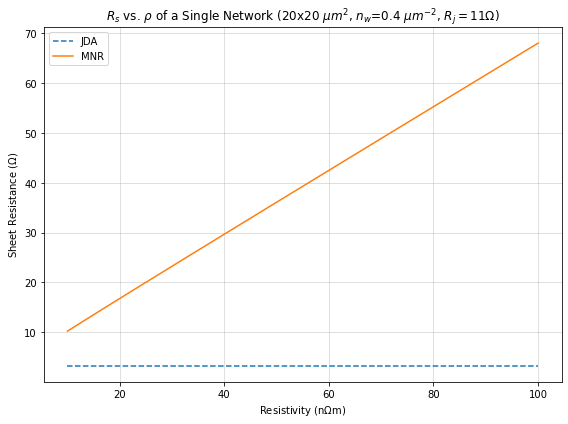

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(rho_array, Rs_list_JDA, "--", label="JDA")
ax.plot(rho_array, Rs_list_MNR, label="MNR")
ax.set_xlabel(r"Resistivity (n$\Omega $m)")
ax.set_ylabel(r"Sheet Resistance ($\Omega$)")
ax.set_title(r"$R_s$ vs. $\rho$ of a Single Network (20x20 $\mu m^{2}$, $n_w$=0.4 $\mu m^{-2}$, $R_j=11\Omega$)")
ax.legend()
ax.grid(alpha=0.5)
fig.tight_layout()
# fig.savefig("figs/Sheet Resistance (Voltage)/fig2.jpg")

## R_s versus diameter Single Network

In [13]:
def resist_func(density, voltage, diameter, R_j, NWN_type="JDA"):
    density *= units["l0"]**2
    voltage /= units["v0"]
    diameter /= units["D0"]
    R_j /= units["Ron"]
    size = 20.0 / units["l0"]

    # Create NWN
    NWN = create_NWN(size=size, conductance=1/R_j, density=density, diameter=diameter, seed=123)
    left, right = add_electrodes(NWN, "left", "right")
    if NWN_type == "MNR":
        convert_NWN_to_MNR(NWN)

    # Solve network voltages to get sheet resistance
    current = solve_network(NWN, left, right, voltage)[-1]
    return (voltage / current) * units["Ron"]

In [14]:
D_array = np.linspace(20, 100, 400)
with Parallel(n_jobs=-1, verbose=9) as parallel:
    Rs_list_JDA = parallel([delayed(resist_func)(0.4, 10, D, 11, "JDA") for D in D_array])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 377 out of 400 | elapsed:    6.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    6.3s finished


In [15]:
D_array = np.linspace(20, 100, 400)
with Parallel(n_jobs=-1, verbose=9) as parallel:
    Rs_list_MNR = parallel([delayed(resist_func)(0.4, 10, D, 11, "MNR") for D in D_array])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 314 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   14.1s finished


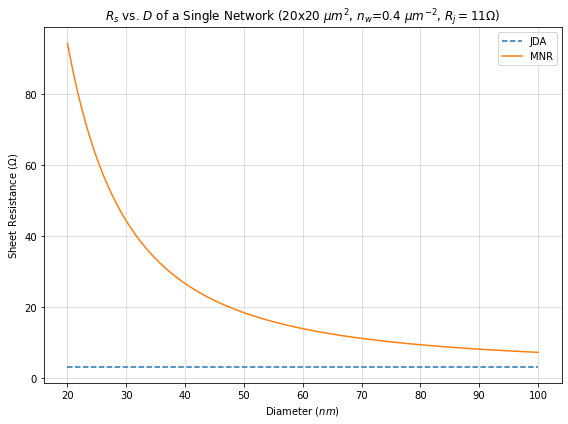

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(D_array, Rs_list_JDA, "--", label="JDA")
ax.plot(D_array, Rs_list_MNR, label="MNR")
ax.set_xlabel(r"Diameter ($nm$)")
ax.set_ylabel(r"Sheet Resistance ($\Omega$)")
ax.set_title(r"$R_s$ vs. $D$ of a Single Network (20x20 $\mu m^{2}$, $n_w$=0.4 $\mu m^{-2}$, $R_j=11\Omega$)")
ax.legend()
ax.grid(alpha=0.5)
fig.tight_layout()
# fig.savefig("figs/Sheet Resistance (Voltage)/fig3.jpg")

## R_s versus wire density Single Network (JDA)

In [23]:
def resist_func(density, voltage, R_j):
    size = 20 / units["l0"]
    density *= units["l0"]**2
    voltage /= units["v0"]
    R_j /= units["Ron"]

    # Create NWN
    NWN = create_NWN(size=size, conductance=1/R_j, density=density)
    left, right = add_electrodes(NWN, "left", "right")

    # Solve network voltages to get sheet resistance
    current = solve_network(NWN, left, right, voltage)[-1]
    return (voltage / current) * units["Ron"]

In [24]:
density_array = np.logspace(-0.6, 0.4, 400)
with Parallel(n_jobs=-1, verbose=9) as parallel:
    Rs_list = parallel([delayed(resist_func)(density, 10, 11) for density in density_array])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 246 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 326 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 372 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   51.5s finished


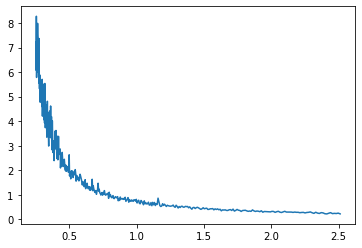

In [25]:
plt.plot(density_array, Rs_list)

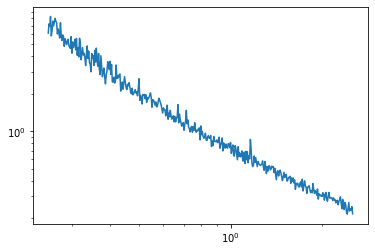

In [26]:
plt.loglog(density_array, Rs_list)

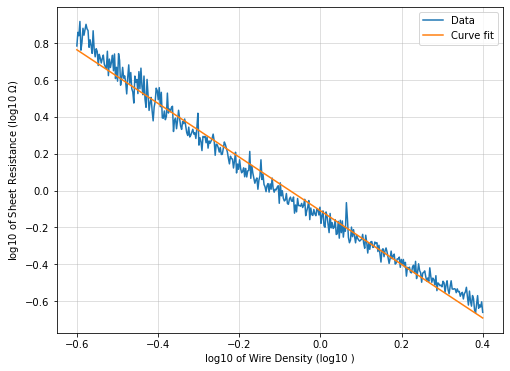

In [27]:
fig, ax = plt.subplots(figsize=(8, 6))
slope, intercept, rvalue, *_ = linregress(np.log10(density_array), np.log10(Rs_list))
ax.plot(np.log10(density_array), np.log10(Rs_list), label="Data")
ax.plot(np.log10(density_array), slope*np.log10(density_array) + intercept, label="Curve fit")
ax.set_xlabel(r"log10 of Wire Density (log10 )")
ax.set_ylabel(r"log10 of Sheet Resistance (log10 $\Omega$)")
ax.legend()
ax.grid(alpha=0.5)

In [28]:
print(f"log-log Plot:\nSlope: {slope:.5f}\nIntercept: {intercept:.5f}\nR^2: {rvalue**2:.5f}")

log-log Plot:
Slope: -1.45637
Intercept: -0.10958
R^2: 0.98395


## R_s versus wire density Ensemble (JDA)

In [29]:
def resist_func(density, voltage, R_j):
    size = 20 / units["l0"]
    density *= units["l0"]**2
    voltage /= units["v0"]
    R_j /= units["Ron"]

    # Create NWN
    NWN = create_NWN(size=size, conductance=1/R_j, density=density)
    left, right = add_electrodes(NWN, "left", "right")

    # Solve network voltages to get sheet resistance
    current = solve_network(NWN, left, right, voltage)[-1]
    return (voltage / current) * units["Ron"]

In [30]:
repeat_num = 40
density_array = np.linspace(0.25, 0.6, 15)

with Parallel(n_jobs=-1, verbose=9) as parallel:
    Rs_list = parallel([delayed(resist_func)(density, 30, 11) for density in density_array.repeat(repeat_num)])

Rs_list = np.array(Rs_list).reshape((-1, repeat_num))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 412 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   11.3s finished


In [31]:
avg = np.mean(Rs_list, axis=1)
std = np.std(Rs_list, axis=1)

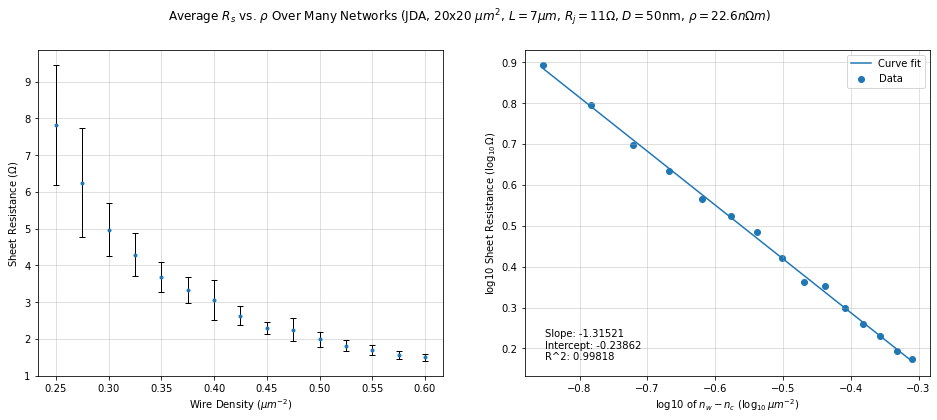

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(r"Average $R_s$ vs. $\rho$ Over Many Networks (JDA, 20x20 $\mu m^2$, $L=7\mu m$, $R_j=11\Omega$, $D=50$nm, $\rho=22.6n\Omega m$)")

ax1.errorbar(density_array, avg, fmt=".", yerr=std, capsize=3, elinewidth=1, ecolor="black")
ax1.set_xlabel(r"Wire Density ($\mu m^{-2}$)")
ax1.set_ylabel(r"Sheet Resistance ($\Omega$)")
ax1.grid(alpha=0.5)

crit = 0.11
log_crit_array = np.log10(density_array - crit)
slope, intercept, rvalue, *_ = linregress(log_crit_array, np.log10(avg))

ax2.scatter(log_crit_array, np.log10(avg), label="Data")
ax2.plot(log_crit_array, slope*log_crit_array + intercept, label="Curve fit")
ax2.text(0.05, 0.05, f"Slope: {slope:.5f}\nIntercept: {intercept:.5f}\nR^2: {rvalue**2:.5f}", transform=ax2.transAxes)
ax2.set_xlabel(r"log10 of $n_w - n_c$ ($\log_{10}\,\mu m^{-2}$)")
ax2.set_ylabel(r"log10 Sheet Resistance ($\log_{10}\,\Omega$)")
ax2.legend()
ax2.grid(alpha=0.5)

# fig.savefig("figs/Sheet Resistance (Voltage)/fig4.jpg")

## Network ensembles MNR

In [34]:
def resist_func(density, voltage, R_j):
    size = 20 / units["l0"]
    density *= units["l0"]**2
    voltage /= units["v0"]
    R_j /= units["Ron"]

    # Create NWN
    NWN = create_NWN(size=size, conductance=1/R_j, density=density)
    left, right = add_electrodes(NWN, "left", "right")
    convert_NWN_to_MNR(NWN)

    # Solve network voltages to get sheet resistance
    current = solve_network(NWN, left, right, voltage)[-1]
    return (voltage / current) * units["Ron"]

In [35]:
repeat_num = 30
density_array = np.linspace(0.25, 0.6, 20)

with Parallel(n_jobs=-1, verbose=9) as parallel:
    Rs_list = parallel([delayed(resist_func)(density, 30, 11) for density in density_array.repeat(repeat_num)])

Rs_list = np.array(Rs_list).reshape((-1, repeat_num))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 432 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 482 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   25.0s finished


In [36]:
avg = np.mean(Rs_list, axis=1)
std = np.std(Rs_list, axis=1)

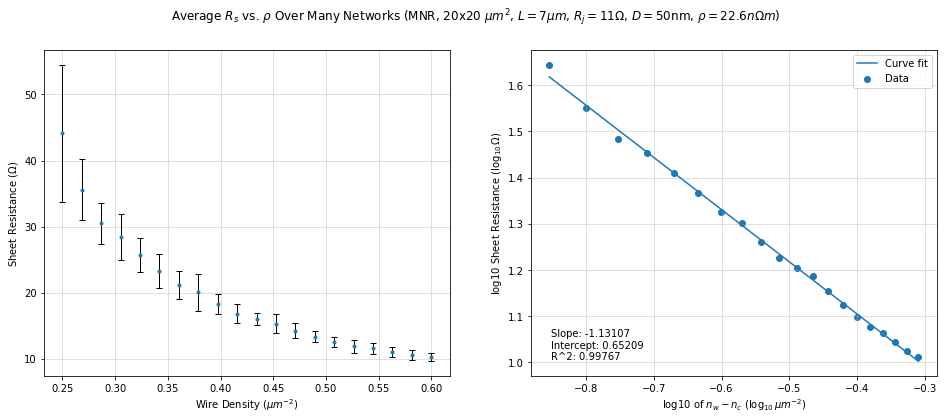

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(r"Average $R_s$ vs. $\rho$ Over Many Networks (MNR, 20x20 $\mu m^2$, $L=7\mu m$, $R_j=11\Omega$, $D=50$nm, $\rho=22.6n\Omega m$)")

ax1.errorbar(density_array, avg, fmt=".", yerr=std, capsize=3, elinewidth=1, ecolor="black")
ax1.set_xlabel(r"Wire Density ($\mu m^{-2}$)")
ax1.set_ylabel(r"Sheet Resistance ($\Omega$)")
ax1.grid(alpha=0.5)

crit = 0.11
slope, intercept, rvalue, *_ = linregress(np.log10(density_array - crit), np.log10(avg))

ax2.scatter(np.log10(density_array - crit), np.log10(avg), label="Data")
ax2.plot(np.log10(density_array - crit), slope*np.log10(density_array - crit) + intercept, label="Curve fit")
ax2.text(0.05, 0.05, f"Slope: {slope:.5f}\nIntercept: {intercept:.5f}\nR^2: {rvalue**2:.5f}", transform=ax2.transAxes)
ax2.set_xlabel(r"log10 of $n_w - n_c$ ($\log_{10}\,\mu m^{-2}$)")
ax2.set_ylabel(r"log10 Sheet Resistance ($\log_{10}\,\Omega$)")
ax2.grid(alpha=0.5)
ax2.legend()

# fig.savefig("figs/Sheet Resistance (Voltage)/fig5.jpg")